# Building and Evaluating Models
Ryan Skinner, December 12, 2018

***

Now that we have explored data imputation, we need to integrate it with model building and evaluation. Because our imputation scheme uses some statistics of the dataset, we need to impute categories only after the train/test split occurs. Luckily the business attribute imputation does not take long.

Our general plan is as follows:
- Select only businesses from Las Vegas (or other cities) based on latitude/longitude
- For each type of model (Naive Bayes, Decision Tree, Random Forest)
    - Split into train/test sets via 5-fold cross-validation
    - For each cross-validation fold
        - Impute business features
        - Fit model
        - Compute error

In [173]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Load the main restaurant features DataFrame!

In [174]:
df = pd.read_pickle('restaurants_vanilla.pkl.bz2')

## Assigning Restaurants to Metro Areas

We need to assign most restaurants to their main city. There are 10 metopolitan areas, and we simply define a radius around their geographic centers within which we consider a restaurant to belong.

In [175]:
def haversine(lat1, lon1, lat2, lon2):
    # Function to compute the distance between two points defined by lag-lon coordinates.
    # Code modified slightly from:
    # https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6
    R = 6373.0
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_kms = R * c
    return total_kms

In [176]:
# The 10 metro areas in the 2018 Yelp Dataset, and their centers in lat-lon coordinates
cities_latlon = [('lasvegas', 36.2, -115.2),
                 ('calgary', 51.0, -114.1),
                 ('phonenix', 33.4, -112.0),
                 ('madison', 43.1, -89.5),
                 ('champaign', 40.1, -88.2),
                 ('cleveland', 41.3, -82.0),
                 ('pittsburgh', 40.3, -80.0),
                 ('toronto', 43.8, -79.3),
                 ('charlotte', 35.2, -81.1),
                 ('montreal', 45.4, -73.6)]
cities_latlon = sorted(cities_latlon, key=lambda x: x[0])
cities_latlon

[('calgary', 51.0, -114.1),
 ('champaign', 40.1, -88.2),
 ('charlotte', 35.2, -81.1),
 ('cleveland', 41.3, -82.0),
 ('lasvegas', 36.2, -115.2),
 ('madison', 43.1, -89.5),
 ('montreal', 45.4, -73.6),
 ('phonenix', 33.4, -112.0),
 ('pittsburgh', 40.3, -80.0),
 ('toronto', 43.8, -79.3)]

In [177]:
# Create boolean column for each city marking a restaurant's membership
for name, lat, lon in cities_latlon:
    df['city_' + name] = (haversine(lat, lon, df['latitude'].values, df['longitude'].values) < 100).astype('float')

Let's do a quick visualization to make sure our clusters of cities are reasonable.

Text(0.97,0.28,'Restaurant Locations\nColored by Metro Area')

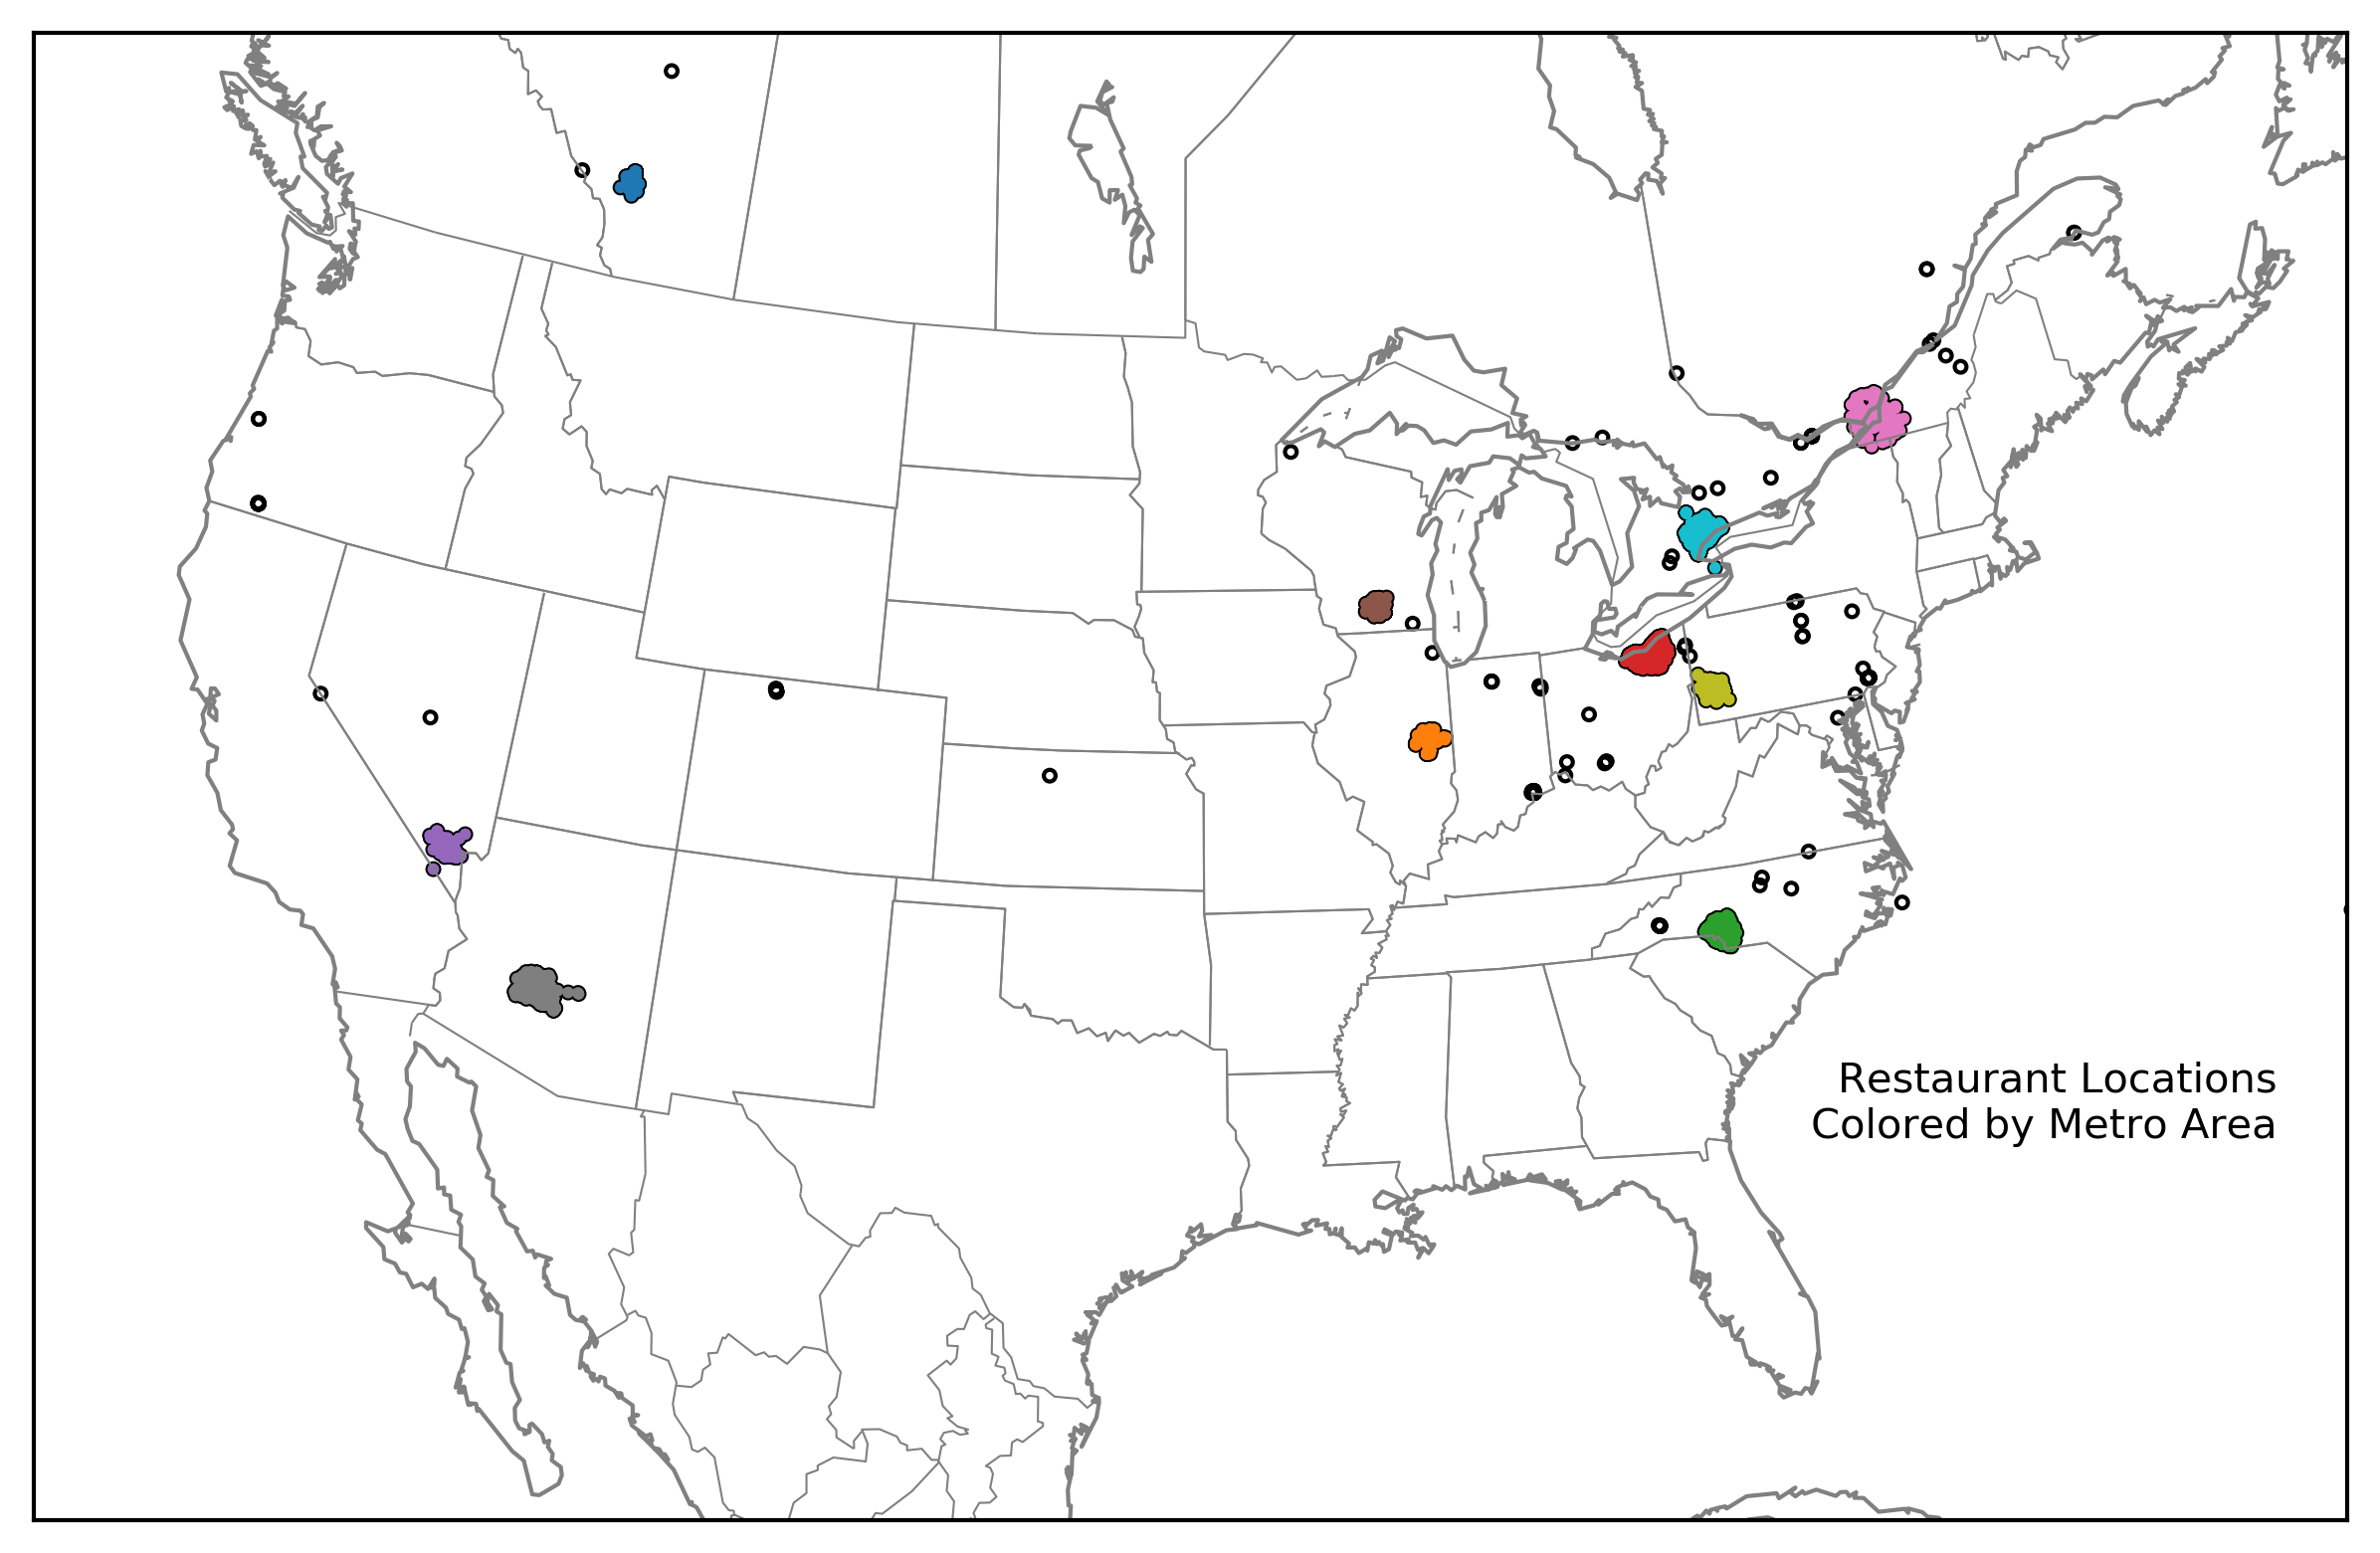

In [178]:
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10, 10), dpi=300)

m = Basemap(projection='lcc', resolution='l', area_thresh=1e4, width=5.6e6, height=3.6e6, lat_0=39.5, lon_0=-95)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(df.longitude.tolist(), df.latitude.tolist(),
          latlon=True, alpha=1, s=8, facecolors='none', edgecolors='k')

for name, lat, lon in cities_latlon:
    m.scatter(df[df['city_' + name] == 1].longitude.tolist(), df[df['city_' + name] == 1].latitude.tolist(),
              latlon=True, alpha=1, s=8, edgecolors='none')

plt.text(0.97, 0.28, 'Restaurant Locations\nColored by Metro Area', color='k',
         ha='right', va='center', transform=plt.gca().transAxes)

Yep, we have 10 nicely-defined metro areas. Some outliers exist, which we will ignore for the remainder of the analysis.

## Function to Impute Missing Business Categories + Attributes

Here we create a function that takes a DataFrame of business categories and attritubes, and imputes the data as described in the preceeding notebook (number 03). This function will be called within each cross-validation fold.

In [179]:
def impute_categories_and_attributes(dataframe, means=None):
    '''Fill in blank values in the restaurant dataframe as described in comments below.'''
    
    df = dataframe.copy()
    
    # Impute business category values to zero if a restaurant does not posess that category
    for bizcategory in [cat for cat in df.columns if 'bizcategory_' in cat]:
        df[bizcategory].fillna(0, inplace=True)
    
    # For the rest of the attributes coded as True=1, False=0, impute unknown values as 0.5
    df_tmp = df.describe().transpose()
    df_tmp = df_tmp[df_tmp['count'] < df_tmp['count'].max()]
    for ind in df_tmp[(df_tmp['min'] == 0) & (df_tmp['max'] == 1)].index:
        df[ind].fillna(0.5, inplace=True)
    
    # For ordinal attributes, impute missing values as the mean of that attribute
    df_tmp = df.describe().transpose()
    df_tmp = df_tmp[df_tmp['count'] < df_tmp['count'].max()]
    if means:
        for ind in df_tmp.index:
            df[ind].fillna(means[ind], inplace=True)
    else:
        means = dict()
        for ind in df_tmp.index:
            means[ind] = df_tmp.loc[ind, 'mean']
            df[ind].fillna(means[ind], inplace=True)
        
    return(df, means)

In [180]:
tmp_df, tmp_means = impute_categories_and_attributes(df)
print(tmp_means)
tmp_df.describe().transpose()['count'].describe()

{'bizattribute_alcohol': 0.91801032293427121, 'bizattribute_noiselevel': 0.90986893583724571, 'bizattribute_restaurantsattire': 0.033593555352545469, 'bizattribute_restaurantspricerange2': 1.6761166872101896}


count       75.0
mean     57173.0
std          0.0
min      57173.0
25%      57173.0
50%      57173.0
75%      57173.0
max      57173.0
Name: count, dtype: float64

Yay, all major attributes are filled; there are no missing values in the dataframe after imputation.

## Importing Business Success Feature

Matt has computed the business success feature. Here we load his data and join it with our business features dataframe.

In [181]:
df_success = pd.read_pickle('features_df_all.pi') # all businesses in Las Vegas
df_success['successful'] = ((df_success['age']>=4.5) &
                            (df_success['is_open']) &
                            (df_success['stars']>=3.5) &
                            (df_success['review_count'] >= 20)).astype('float')
df_success.set_index('business_id', inplace=True)

df_success['num_in_4_weeks'] = df_success['num_in_4_weeks'].astype('float')
df_success['num_in_8_weeks'] = df_success['num_in_8_weeks'].astype('float')
df_success['review_count'] = df_success['review_count'].astype('float')
df_success['is_open'] = df_success['is_open'].astype('float')

df_success.describe().transpose()

count        mean         std        min         25%  \
review_count           28909.0   63.190252  215.792934   3.000000    5.000000   
age                    28909.0    5.702267    3.006578   0.451745    3.329227   
stars                  28909.0    3.731035    1.033686   1.000000    3.000000   
is_open                28909.0    0.815421    0.387963   0.000000    1.000000   
successful             28909.0    0.202532    0.401894   0.000000    0.000000   
num_in_4_weeks         28909.0    2.694905    6.424663   1.000000    1.000000   
num_in_8_weeks         28909.0    3.775537   10.533763   1.000000    1.000000   
first_4_week_review    28909.0    3.904063    1.385142   1.000000    3.000000   
first_8_week_review    28909.0    3.897077    1.355946   1.000000    3.000000   
average_review_length  28909.0  580.007563  251.294738  94.333333  418.179487   

                              50%         75%          max  
review_count            13.000000   41.000000  7968.000000  
age                      5.418207    7.830253    14.146475  
stars                    4.000000    4.500000     5.000000  
is_open                  1.000000    1.000000     1.000000  
successful               0.000000    0.000000     1.000000  
num_in_4_weeks           1.000000    2.000000   194.000000  
num_in_8_weeks           1.000000    3.000000   430.000000  
first_4_week_review      4.500000    5.000000     5.000000  
first_8_week_review      4.416667    5.000000     5.000000  
average_review_length  533.192308  684.482517  3583.000000

## Looking at Correlations

Here we take a quick look at correlations between attributes in Las Vegas

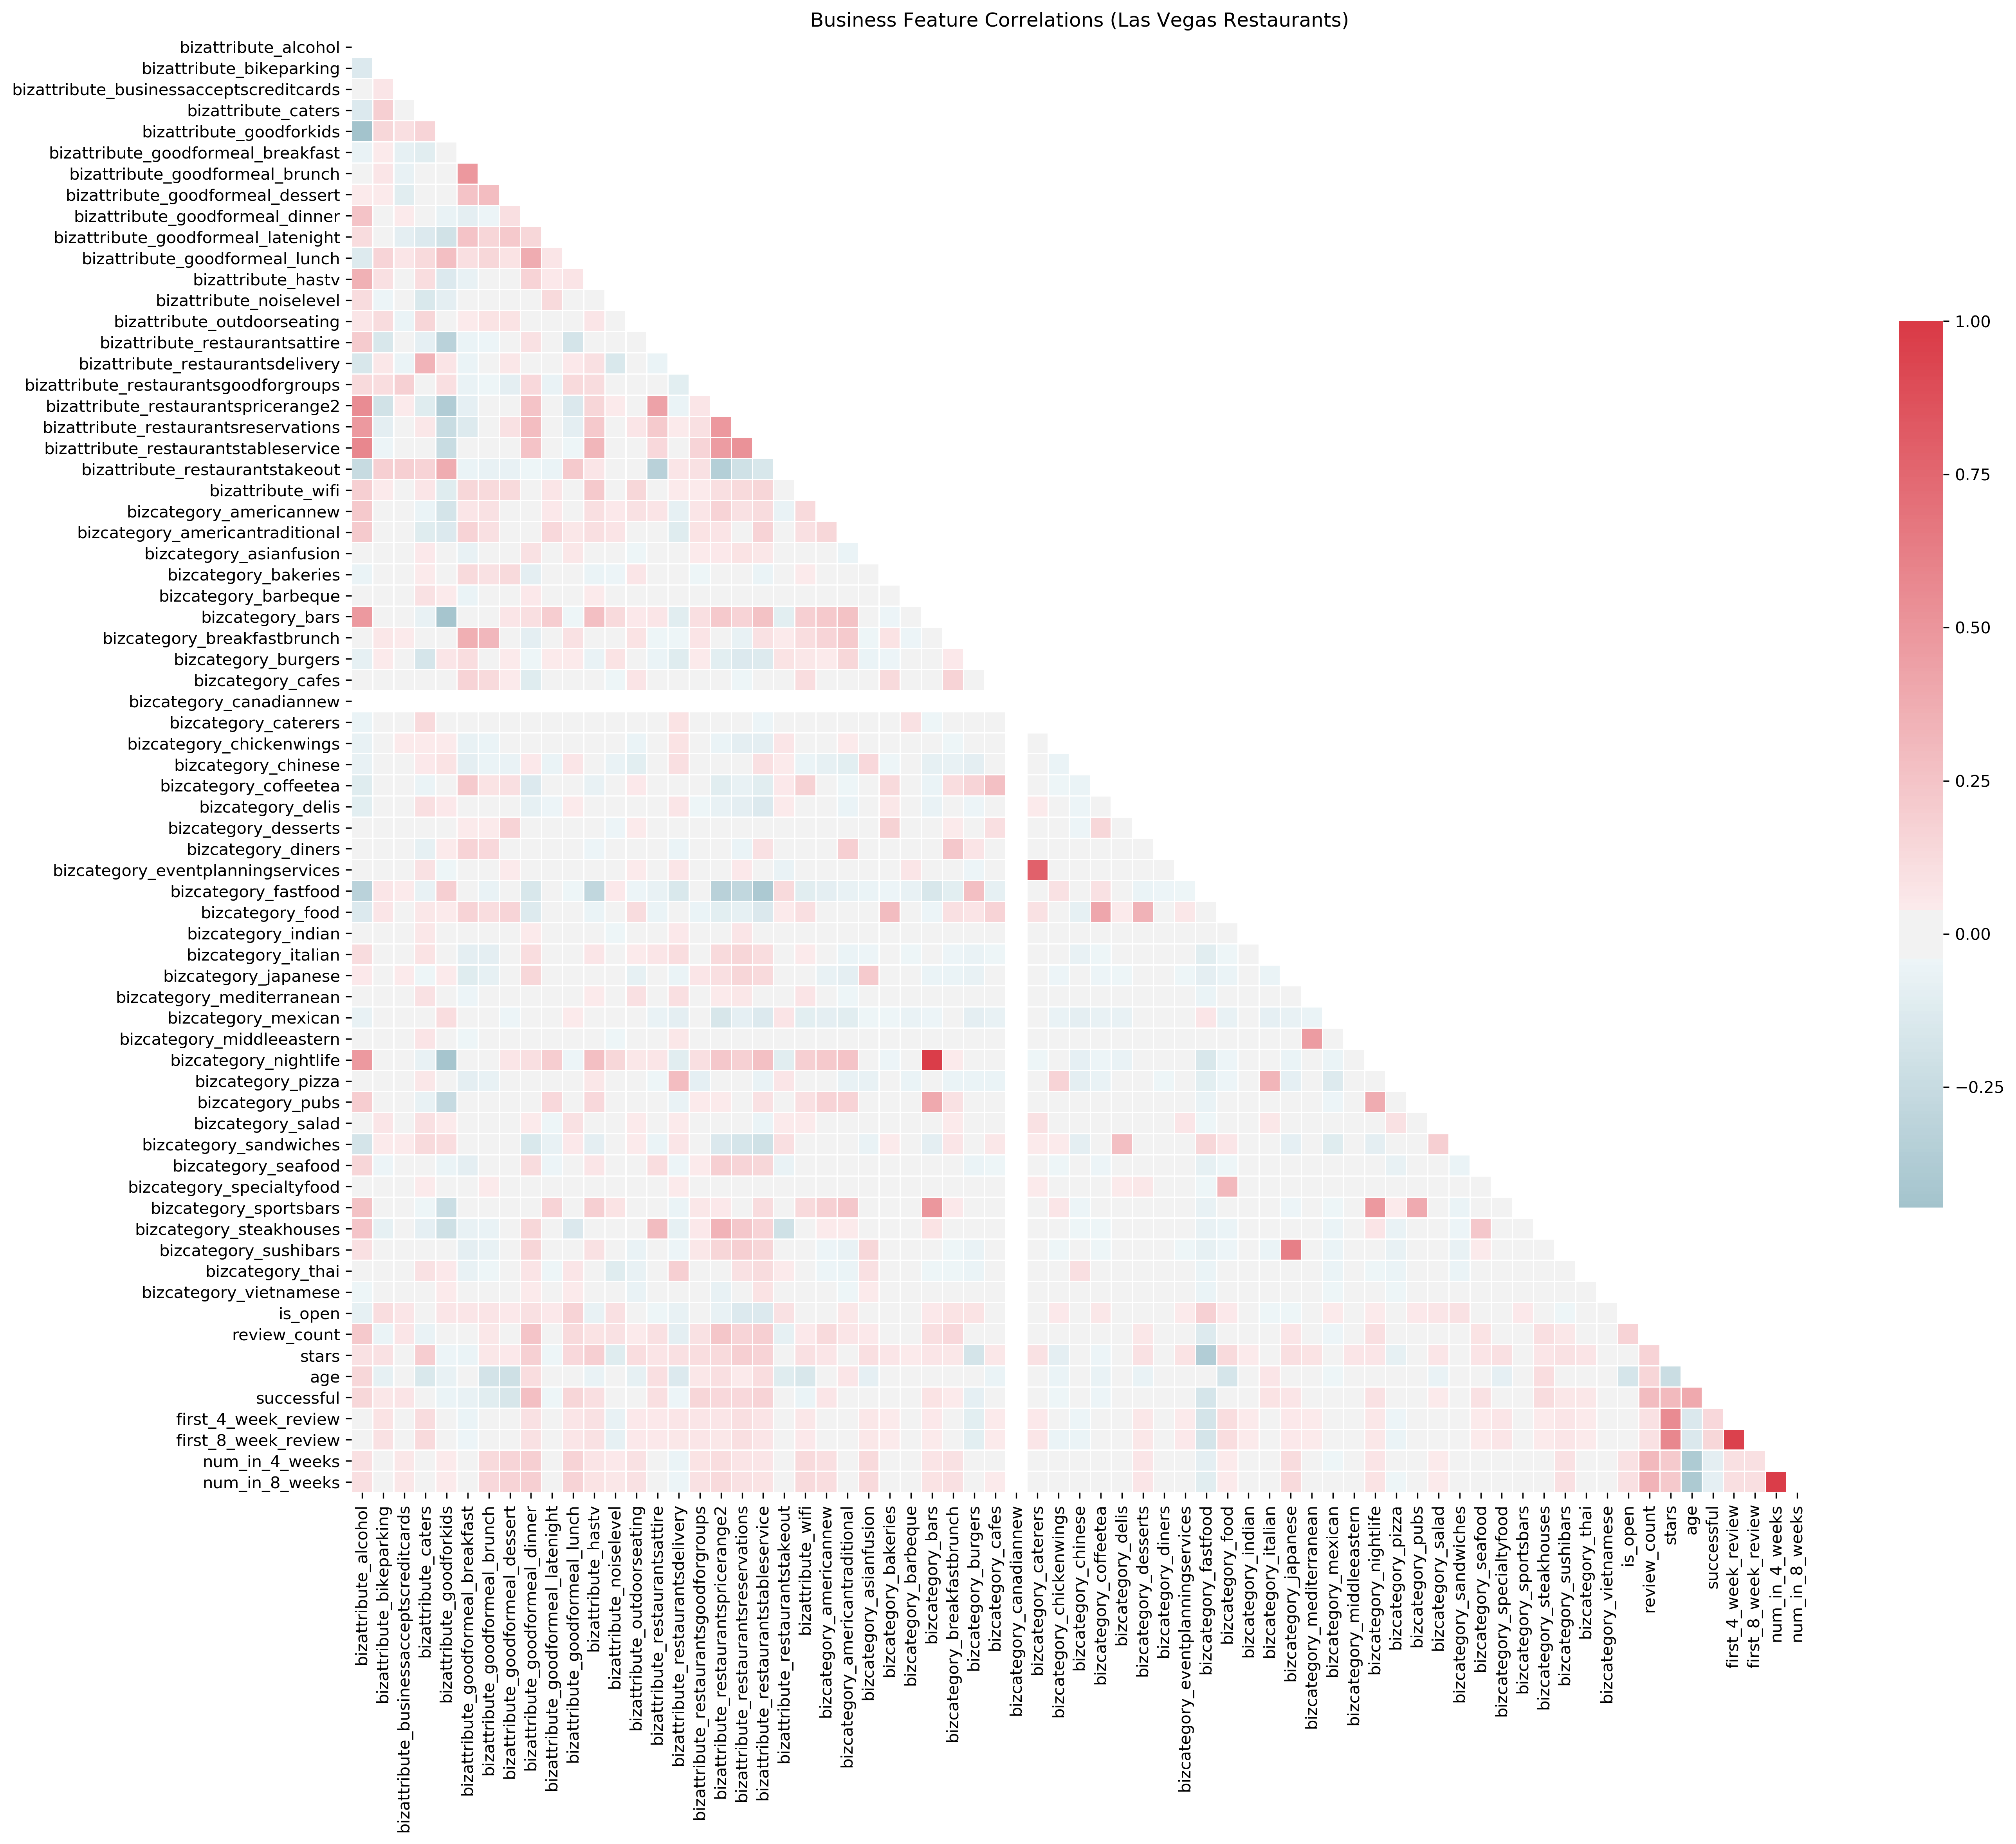

In [184]:
df_imputed, _ = impute_categories_and_attributes(df[df['city_lasvegas'] == 1])
df_imputed = pd.merge(left=df_imputed, right=df_success[['age', 'successful', 'first_4_week_review', 'first_8_week_review', 'num_in_4_weeks', 'num_in_8_weeks']],
                      how='left', left_index=True, right_index=True)
#df_imputed.dropna(axis='index', inplace=True)
df_imputed = df_imputed.drop(columns=['latitude', 'longitude'])
df_imputed = df_imputed.drop(columns=[c for c in df_imputed.columns if 'city_' in c])
correlations = df_imputed.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20), dpi=300)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Business Feature Correlations (Las Vegas Restaurants)')
plt.show()

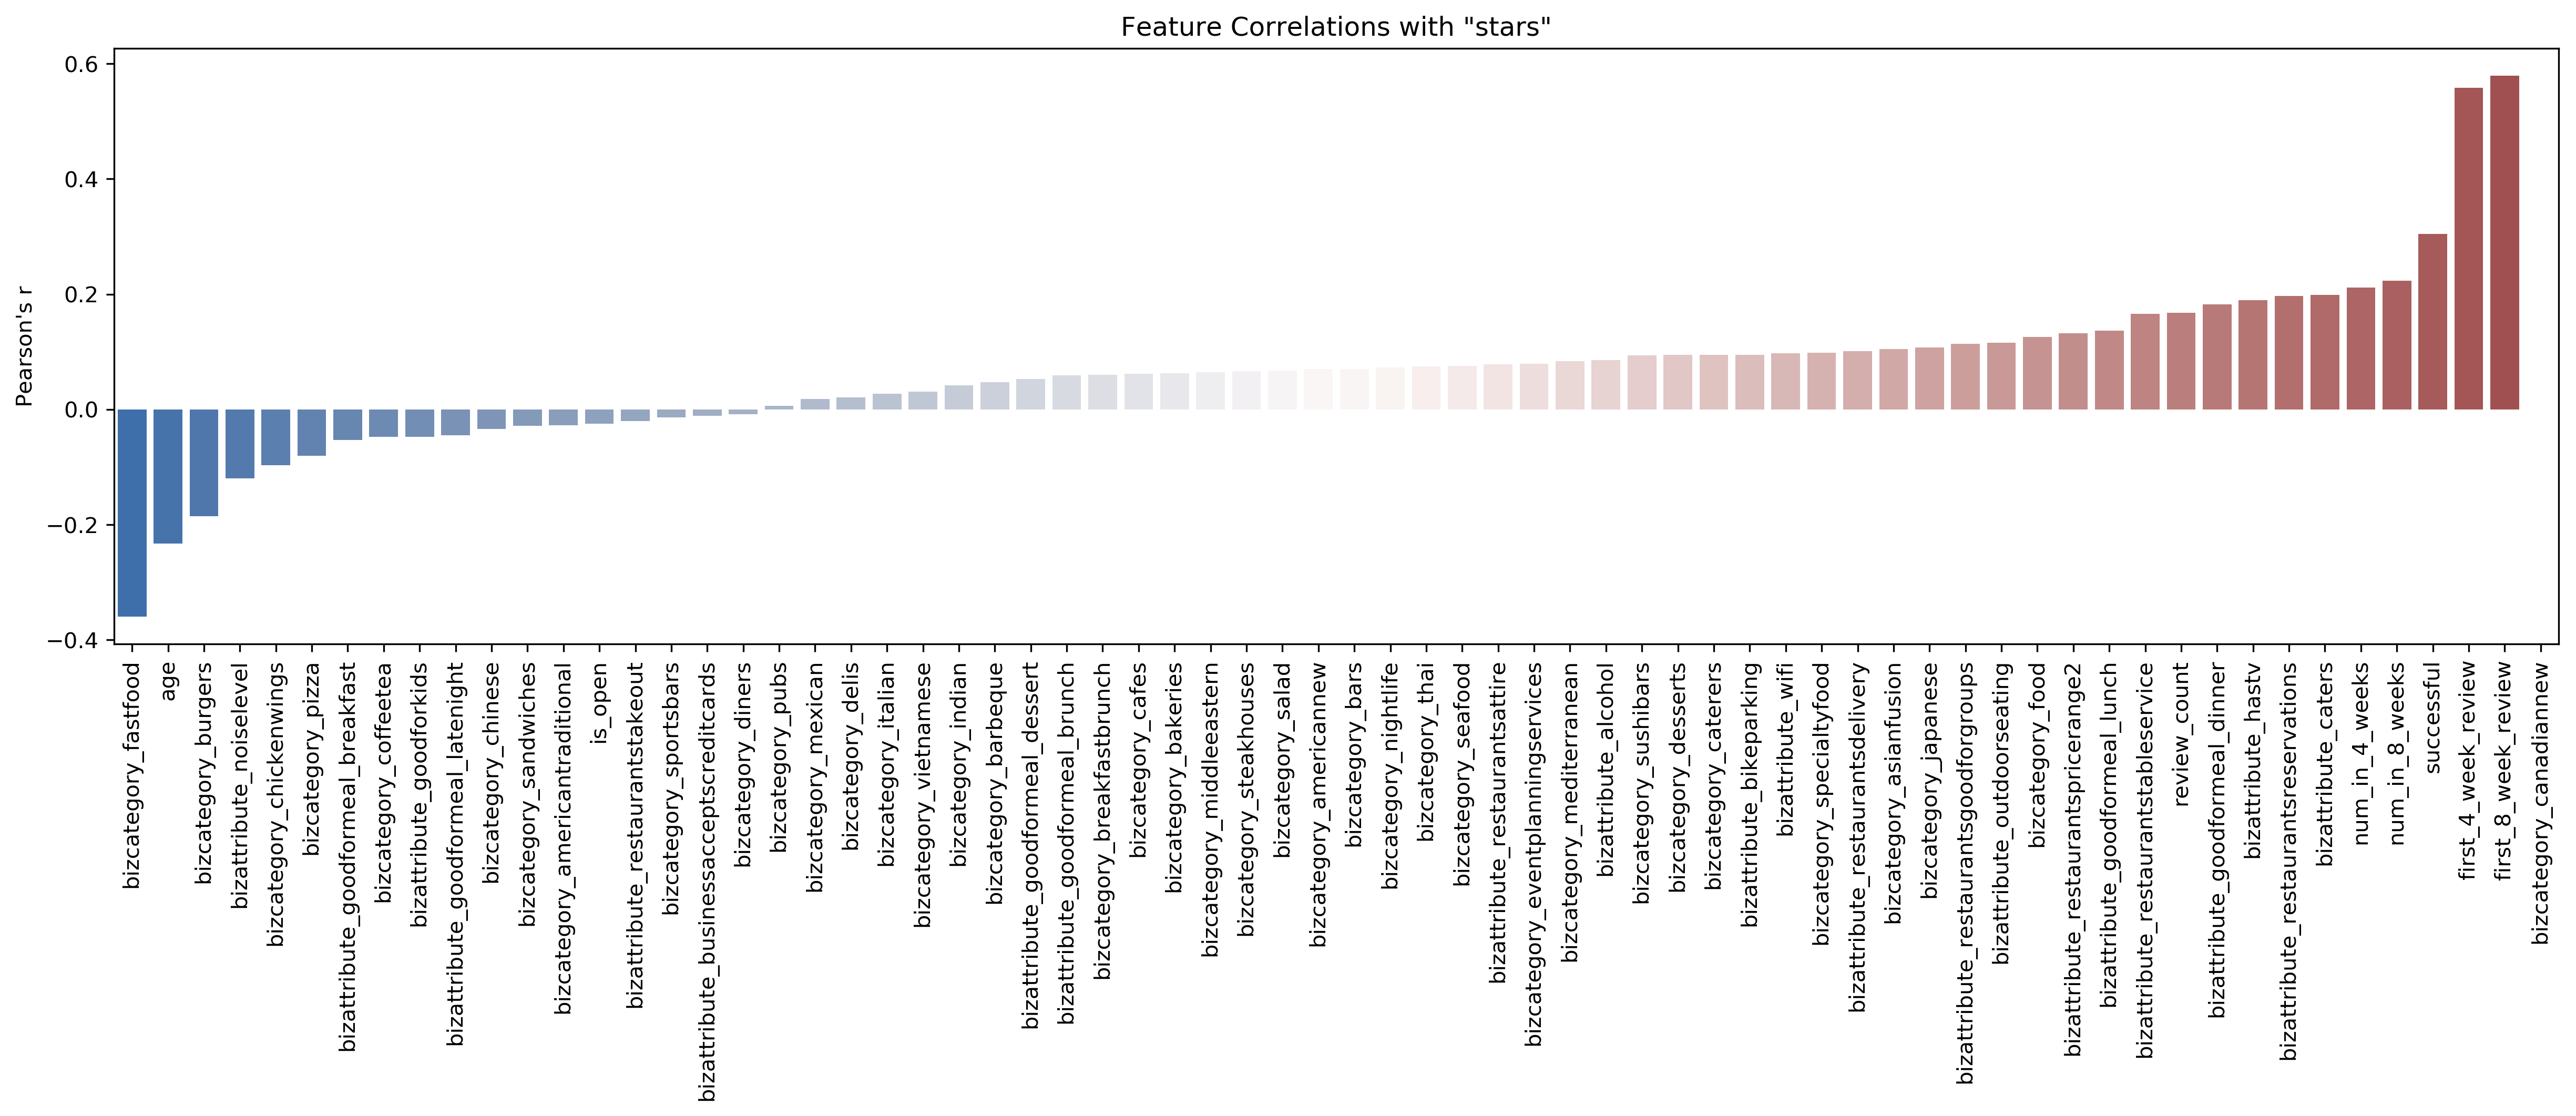

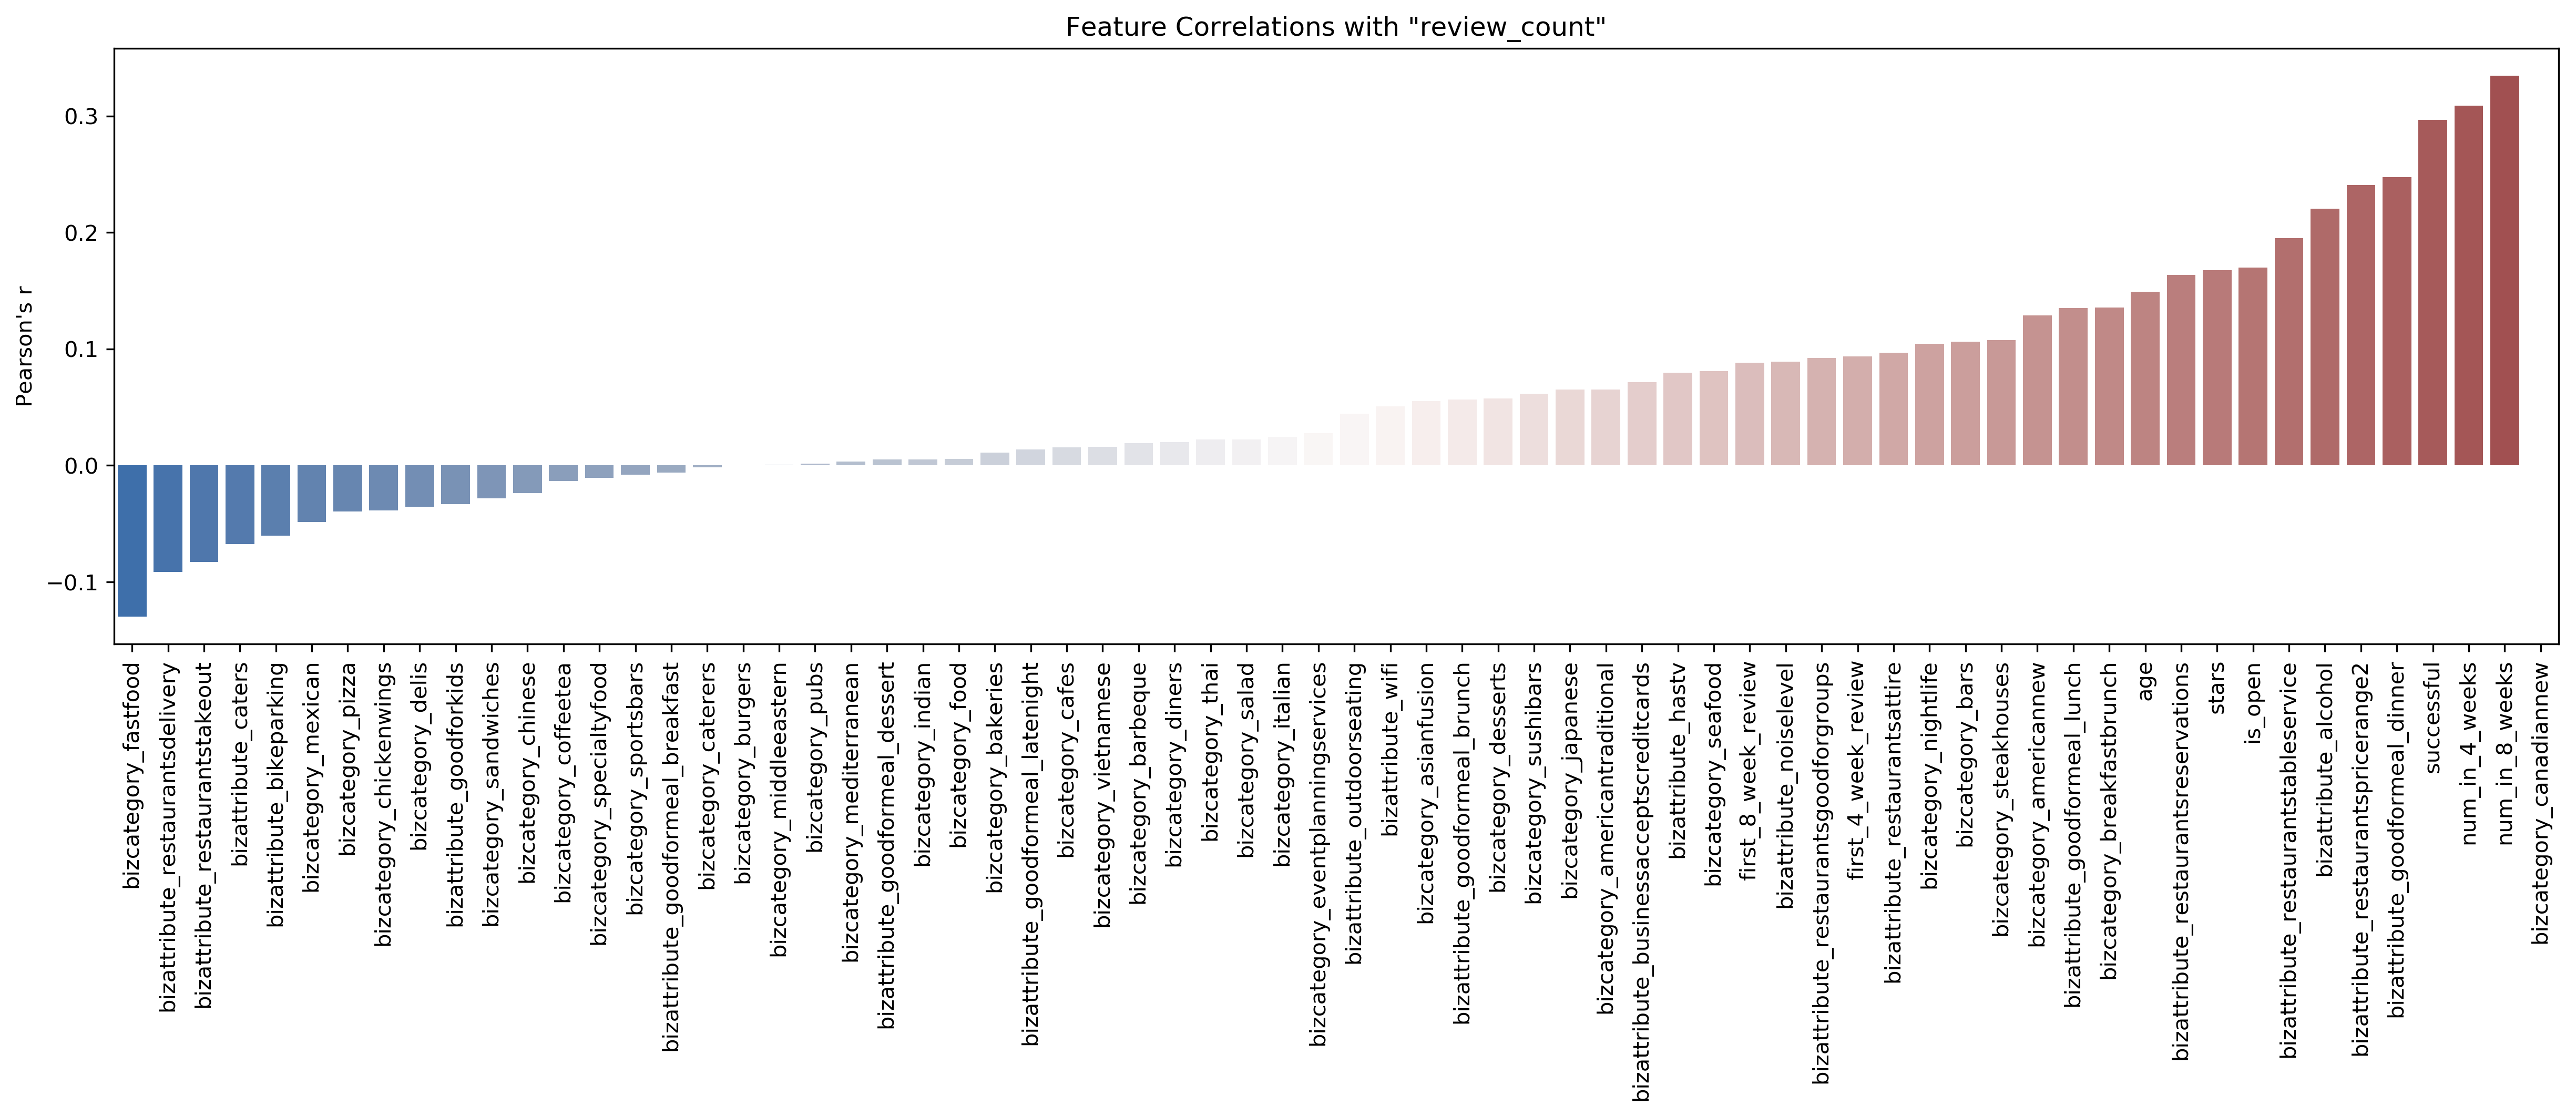

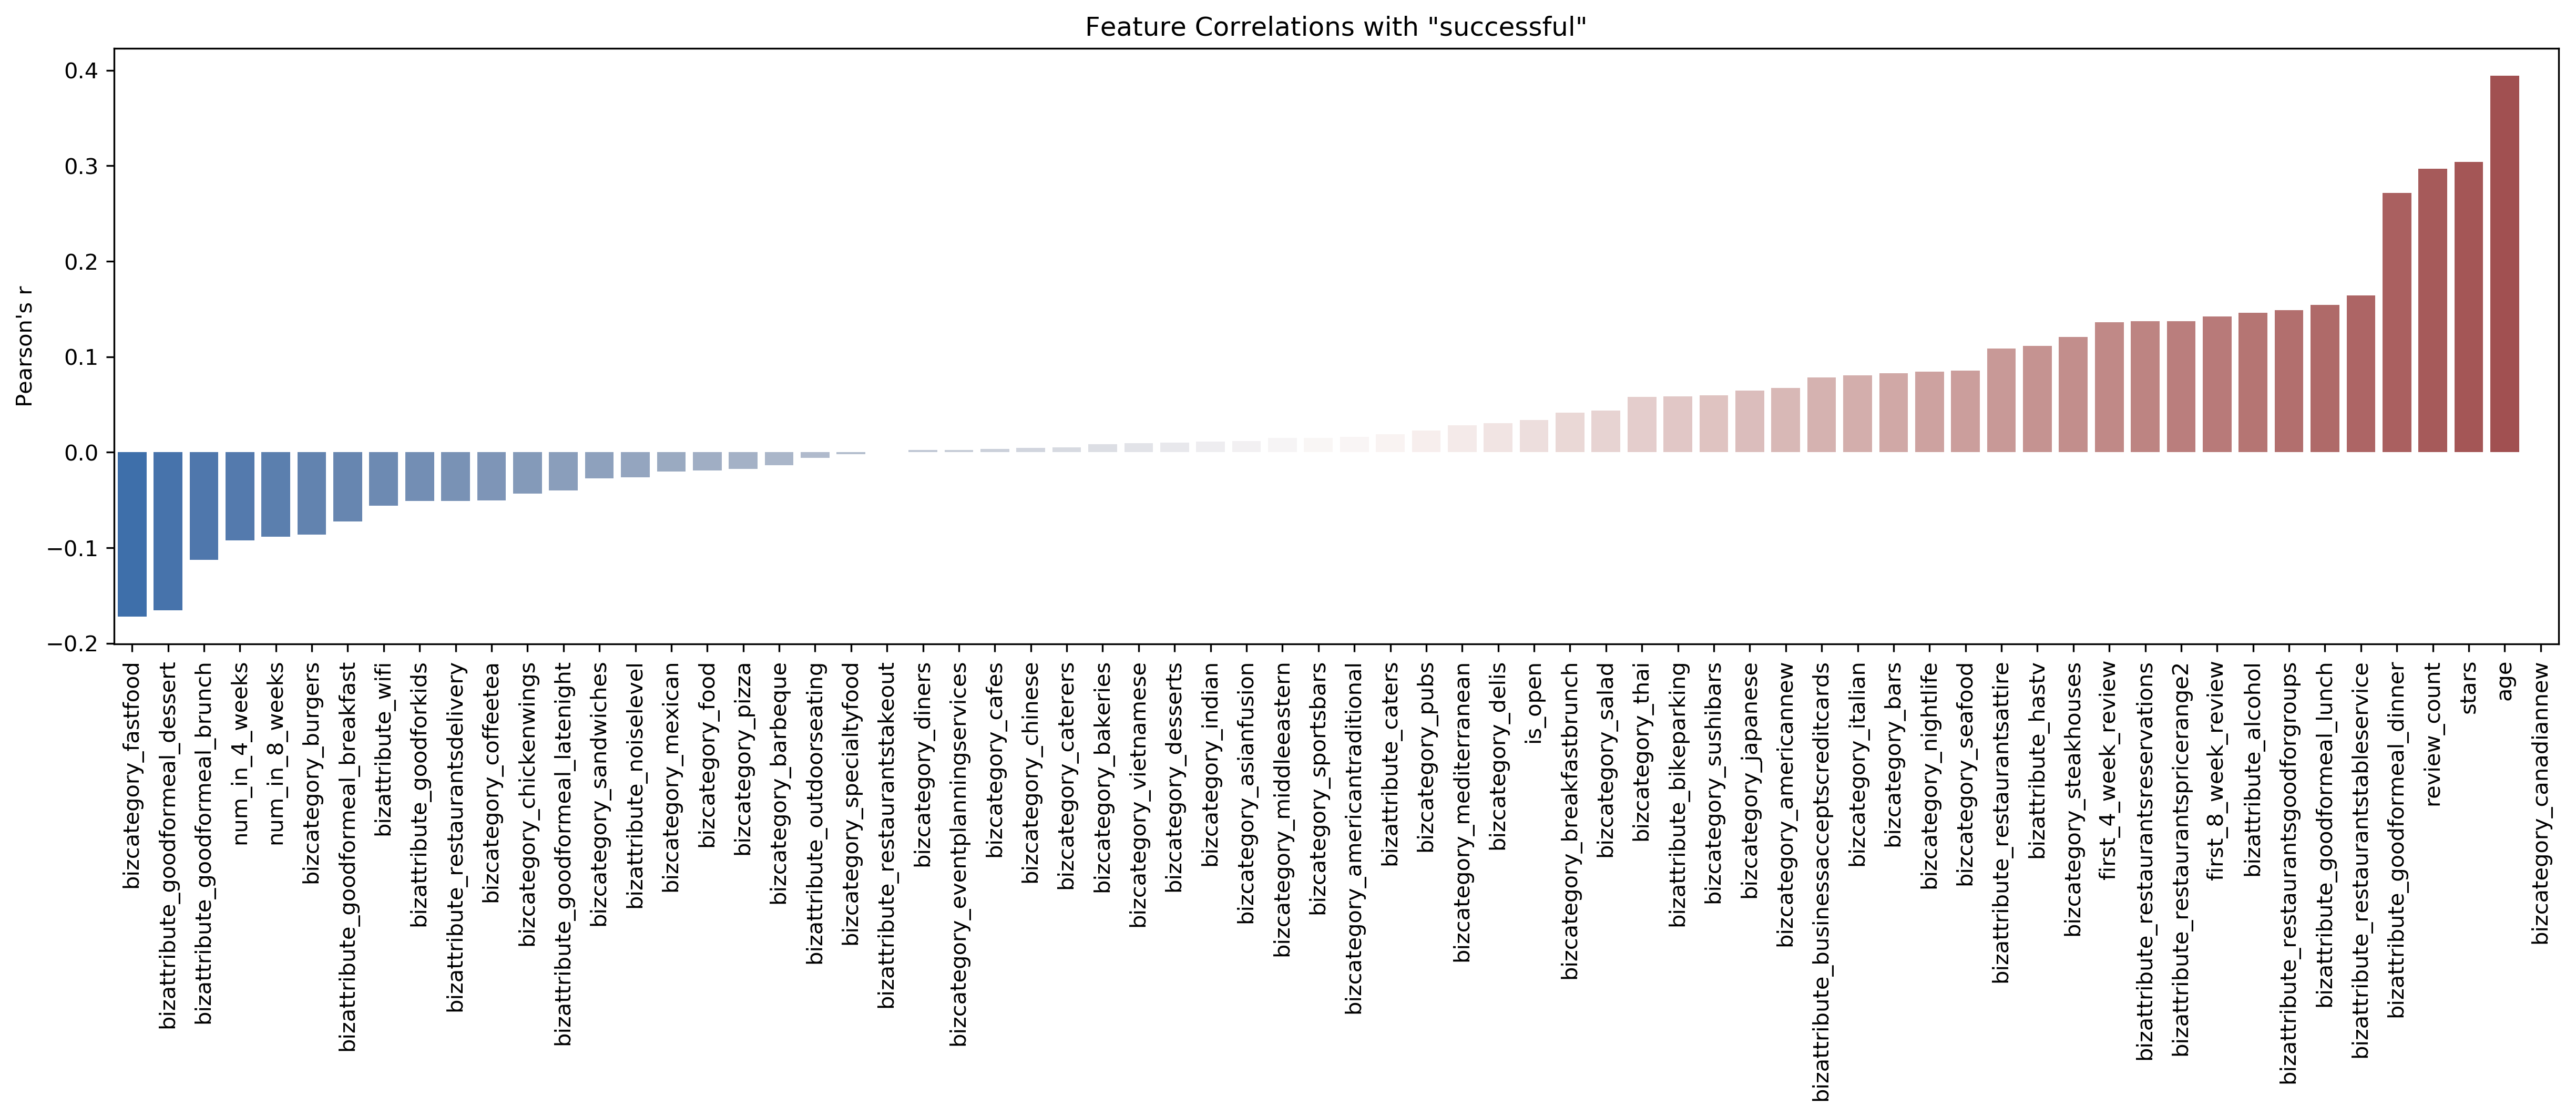

In [185]:
for feature in ['stars', 'review_count', 'successful']:
    tmp = correlations[feature].transpose().drop(feature).sort_values()
    fig, ax = plt.subplots(figsize=[20, 5], dpi=300)
    sns.barplot(tmp.index, tmp.values, palette='vlag')
    plt.ylabel('Pearson\'s r')
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.title('Feature Correlations with "{:s}"'.format(feature))
    plt.show()

## Support Vector Regression for Star Rating

We fit an SVR model for star rating to restaurants in each of the 10 cities individually, and quantify model error with star rating.

In [186]:
print([c for c in df_city.columns if 'city_' in c])
df_city = df[df.city_lasvegas == True]
df_city.shape

['city_lasvegas', 'city_calgary', 'city_phonenix', 'city_madison', 'city_champaign', 'city_cleveland', 'city_pittsburgh', 'city_toronto', 'city_charlotte', 'city_montreal']


(7428, 82)

We'll use `stars` as a proxy for restaurant success, at least to compare attribute importance between cities.

In [187]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import median_absolute_error
from progressbar import ProgressBar

cities = [c for c in df_city.columns if 'city_' in c]

nfolds = 5
svr_median_abs_errors = np.zeros([len(cities), nfolds])

bar = ProgressBar(max_value=len(cities)*nfolds)
for ii, city in bar(enumerate(cities)):
    
    df_city = df[df[city] == True]

    X_full = df_city[[c for c in df_city.columns if 'bizcategory_' in c or 'bizattribute_' in c]]
    y_full = df_city['stars']

    kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)

    for jj, (train, test) in enumerate(kf.split(X_full)):
        bar.update(ii * nfolds + jj)
        
        # Select train features and target, and impute features while saving means derived from certain features
        X_train, means_train = impute_categories_and_attributes(X_full.iloc[train])
        y_train = y_full.iloc[train]
        
        # Do the same thing for the test set, but now just impute using means derived from the training set
        X_test, _ = impute_categories_and_attributes(X_full.iloc[test], means_train)
        y_test = y_full.iloc[test]
        
        # Fit a support vector regressor to the training set and compute its error on the test set
        svr = SVR(kernel='linear')
        svr.fit(X_train, y_train)
        err = median_absolute_error(y_test, svr.predict(X_test))
        svr_median_abs_errors[ii, jj] = err

100% (50 of 50) |#########################| Elapsed Time: 0:04:17 Time: 0:04:17


In [188]:
svr_median_abs_errors

array([[ 0.46948064,  0.44383546,  0.47766233,  0.50397946,  0.48697734],
       [ 0.48942024,  0.55924001,  0.44791303,  0.53392005,  0.48928201],
       [ 0.47224437,  0.46049309,  0.47004607,  0.48481657,  0.45756278],
       [ 0.51200359,  0.48997104,  0.46796164,  0.50172577,  0.51046922],
       [ 0.45091293,  0.44262041,  0.45746756,  0.46753259,  0.44307626],
       [ 0.43285681,  0.45881041,  0.47111679,  0.45738875,  0.45505585],
       [ 0.45295957,  0.45161138,  0.49441243,  0.46897477,  0.46944113],
       [ 0.43291978,  0.4469336 ,  0.45741406,  0.4628367 ,  0.46692351],
       [ 0.4667217 ,  0.49588718,  0.45972682,  0.49099854,  0.48160481],
       [ 0.45340921,  0.46748931,  0.45868756,  0.47222623,  0.4710353 ]])

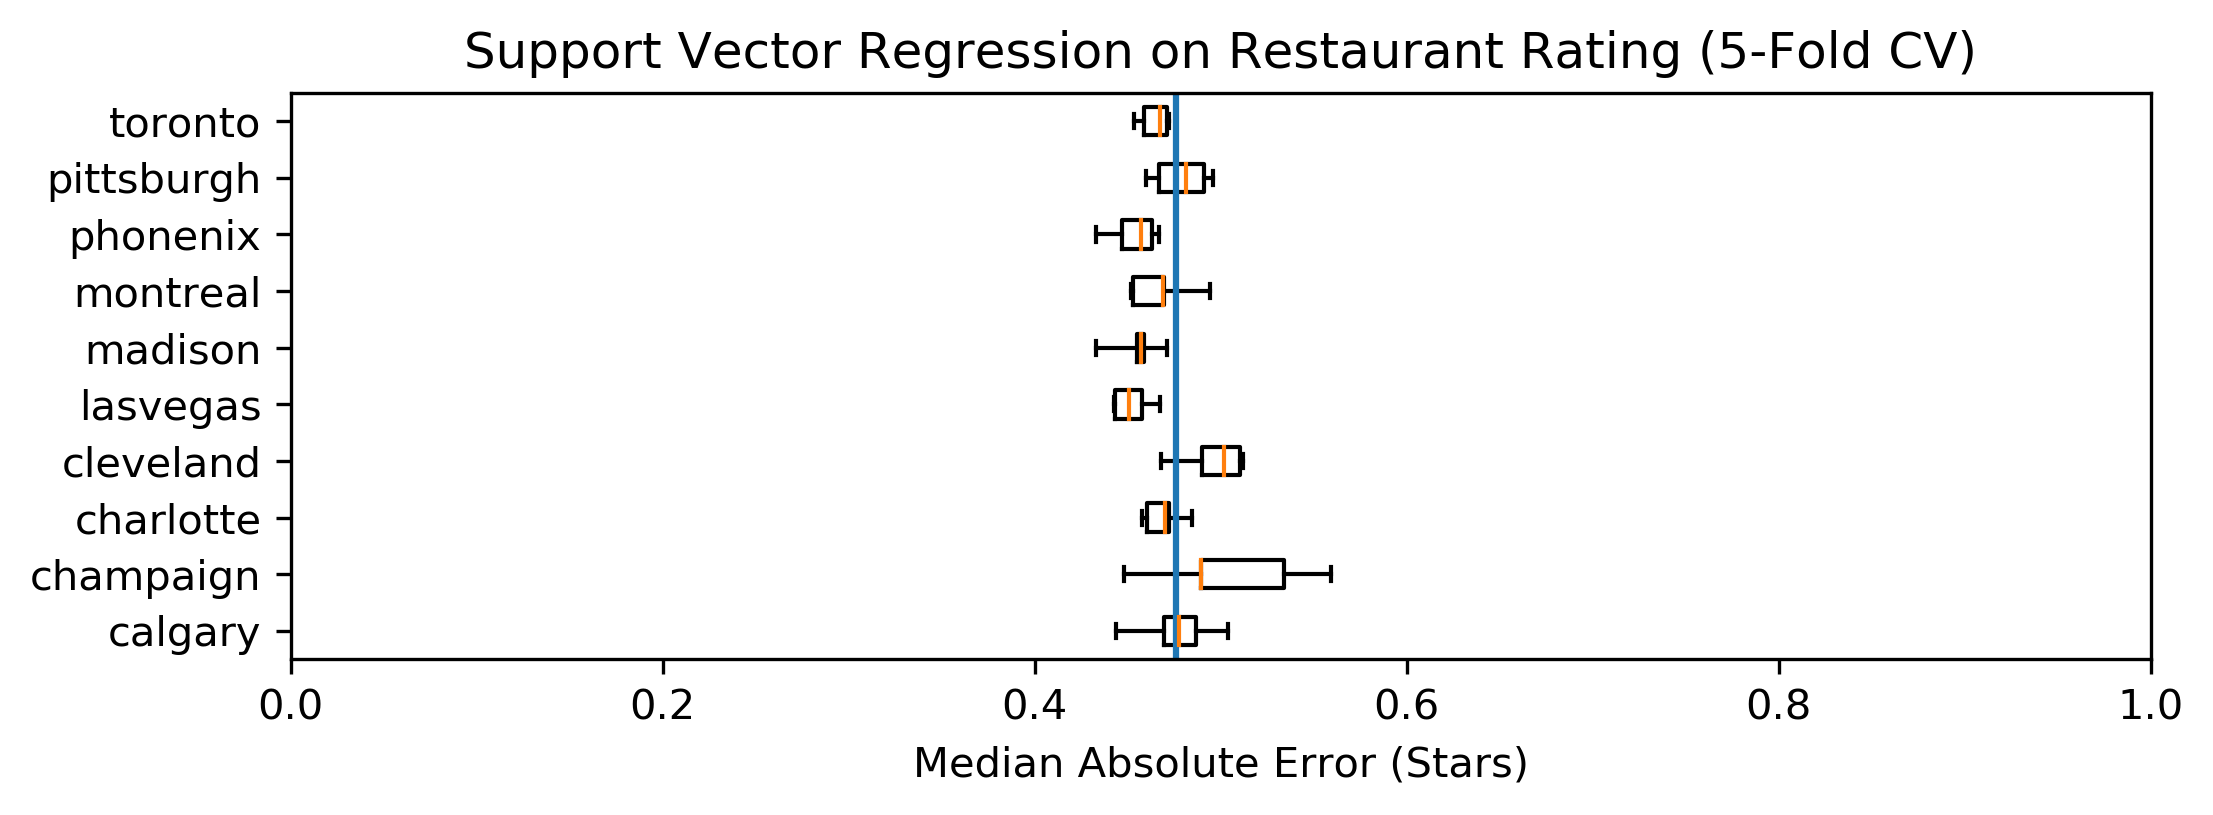

In [189]:
plt.figure(figsize=[8,2.5], dpi=300)
plt.boxplot(svr_median_abs_errors.T, labels=[c[5:] for c in cities], vert=False, whis=np.Inf)
plt.xlim([0, 1])
plt.xlabel('Median Absolute Error (Stars)')
plt.gca().axvline(rr_median_abs_errors.mean().mean())
plt.title('Support Vector Regression on Restaurant Rating ({:d}-Fold CV)'.format(nfolds))
plt.show()

We see that the median absolute error for the support vector regressor is about 0.5 stars in rating. This is pretty good, at least good enough that our models aren't wildly inaccurate. We should be able to take model 

## Ridge Regression for Star Rating

Now we fit a ridge regression model for star rating, since it is more explainable.

In [190]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import median_absolute_error
from progressbar import ProgressBar

cities = [c for c in df_city.columns if 'city_' in c]

nfolds = 5
rr_median_abs_errors = np.zeros([len(cities), nfolds])

bar = ProgressBar(max_value=len(cities)*nfolds)
for ii, city in bar(enumerate(cities)):
    
    df_city = df[df[city] == True]

    X_full = df_city[[c for c in df_city.columns if 'bizcategory_' in c or 'bizattribute_' in c]]
    y_full = df_city['stars']

    kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)

    for jj, (train, test) in enumerate(kf.split(X_full)):
        bar.update(ii * nfolds + jj)
        
        # Select train features and target, and impute features while saving means derived from certain features
        X_train, means_train = impute_categories_and_attributes(X_full.iloc[train])
        y_train = y_full.iloc[train]
        
        # Do the same thing for the test set, but now just impute using means derived from the training set
        X_test, _ = impute_categories_and_attributes(X_full.iloc[test], means_train)
        y_test = y_full.iloc[test]
        
        # Fit a support vector regressor to the training set and compute its error on the test set
        rr = Ridge()
        rr.fit(X_train, y_train)
        err = median_absolute_error(y_test, rr.predict(X_test))
        rr_median_abs_errors[ii, jj] = err

100% (50 of 50) |#########################| Elapsed Time: 0:00:22 Time: 0:00:22


In [191]:
rr_median_abs_errors

array([[ 0.49214808,  0.45399609,  0.49343525,  0.49806123,  0.48079456],
       [ 0.48138937,  0.60014205,  0.41457825,  0.50768011,  0.49863483],
       [ 0.48093337,  0.45907611,  0.47886752,  0.49800934,  0.4609969 ],
       [ 0.52480041,  0.49072053,  0.46271334,  0.51221349,  0.51388217],
       [ 0.45135876,  0.45709437,  0.45992166,  0.47878915,  0.43818549],
       [ 0.4334184 ,  0.44434649,  0.45337122,  0.46299283,  0.48672367],
       [ 0.45923903,  0.45257499,  0.49572912,  0.47698632,  0.49786215],
       [ 0.44024131,  0.45412118,  0.45345553,  0.46616217,  0.4728736 ],
       [ 0.47372333,  0.50259622,  0.47814198,  0.49535048,  0.48427723],
       [ 0.4555199 ,  0.46814711,  0.46742695,  0.47181687,  0.47529734]])

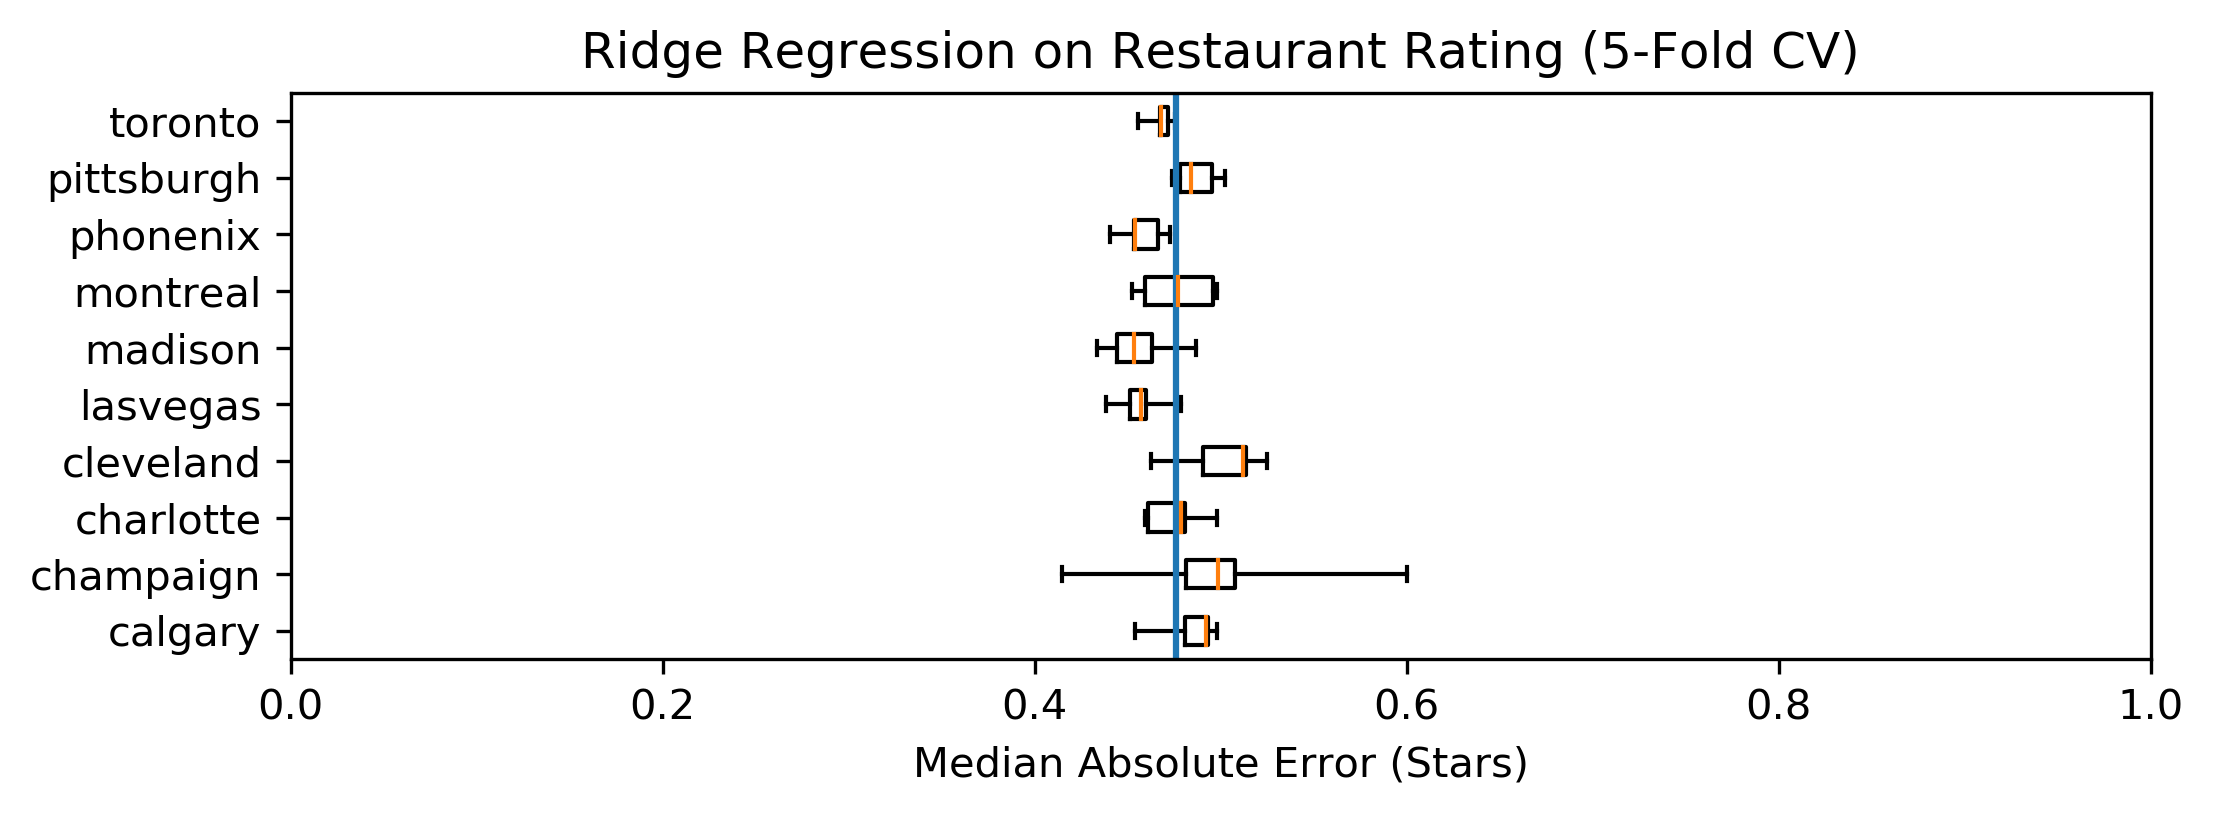

In [192]:
plt.figure(figsize=[8,2.5], dpi=300)
plt.boxplot(rr_median_abs_errors.T, labels=[c[5:] for c in cities], vert=False, whis=np.Inf)
plt.xlim([0, 1])
plt.gca().axvline(rr_median_abs_errors.mean().mean())
plt.xlabel('Median Absolute Error (Stars)')
plt.title('Ridge Regression on Restaurant Rating ({:d}-Fold CV)'.format(nfolds))
plt.show()

Ridge regression is comparably accurate across all cities to SVR.

## Ridge Regression Accross Cities

Let's now fit a model to each city individually (no test/train split), and see what the model coefficients are!

In [193]:
df_imputed, _ = impute_categories_and_attributes(df)

In [194]:
cities = np.sort([c for c in df_city.columns if 'city_' in c])

coeffs = []

bar = ProgressBar(max_value=len(cities))
for ii, city in bar(enumerate(cities)):
    bar.update(ii)
    
    df_city = df_imputed[df_imputed[city] == True]
    df_city.sort_index(ascending=False, inplace=True)

    X_full = df_city[[c for c in df_city.columns if 'bizcategory_' in c or 'bizattribute_' in c]]
    y_full = df_city['stars']
        
    # Fit a support vector regressor to the training set and compute its error on the test set
    rr = Ridge()
    rr.fit(X_full, y_full)
    coeffs.append(rr.coef_)

feats = X_full.columns.tolist()
coeffs = np.array(coeffs).T

# Sort coefficients, their means, and feature names by mean coefficient magnitude
means = coeffs.mean(axis=1)
order = means.argsort()
means = means[order]
coeffs = coeffs[order]
feats = np.array(feats)[order]

100% (10 of 10) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


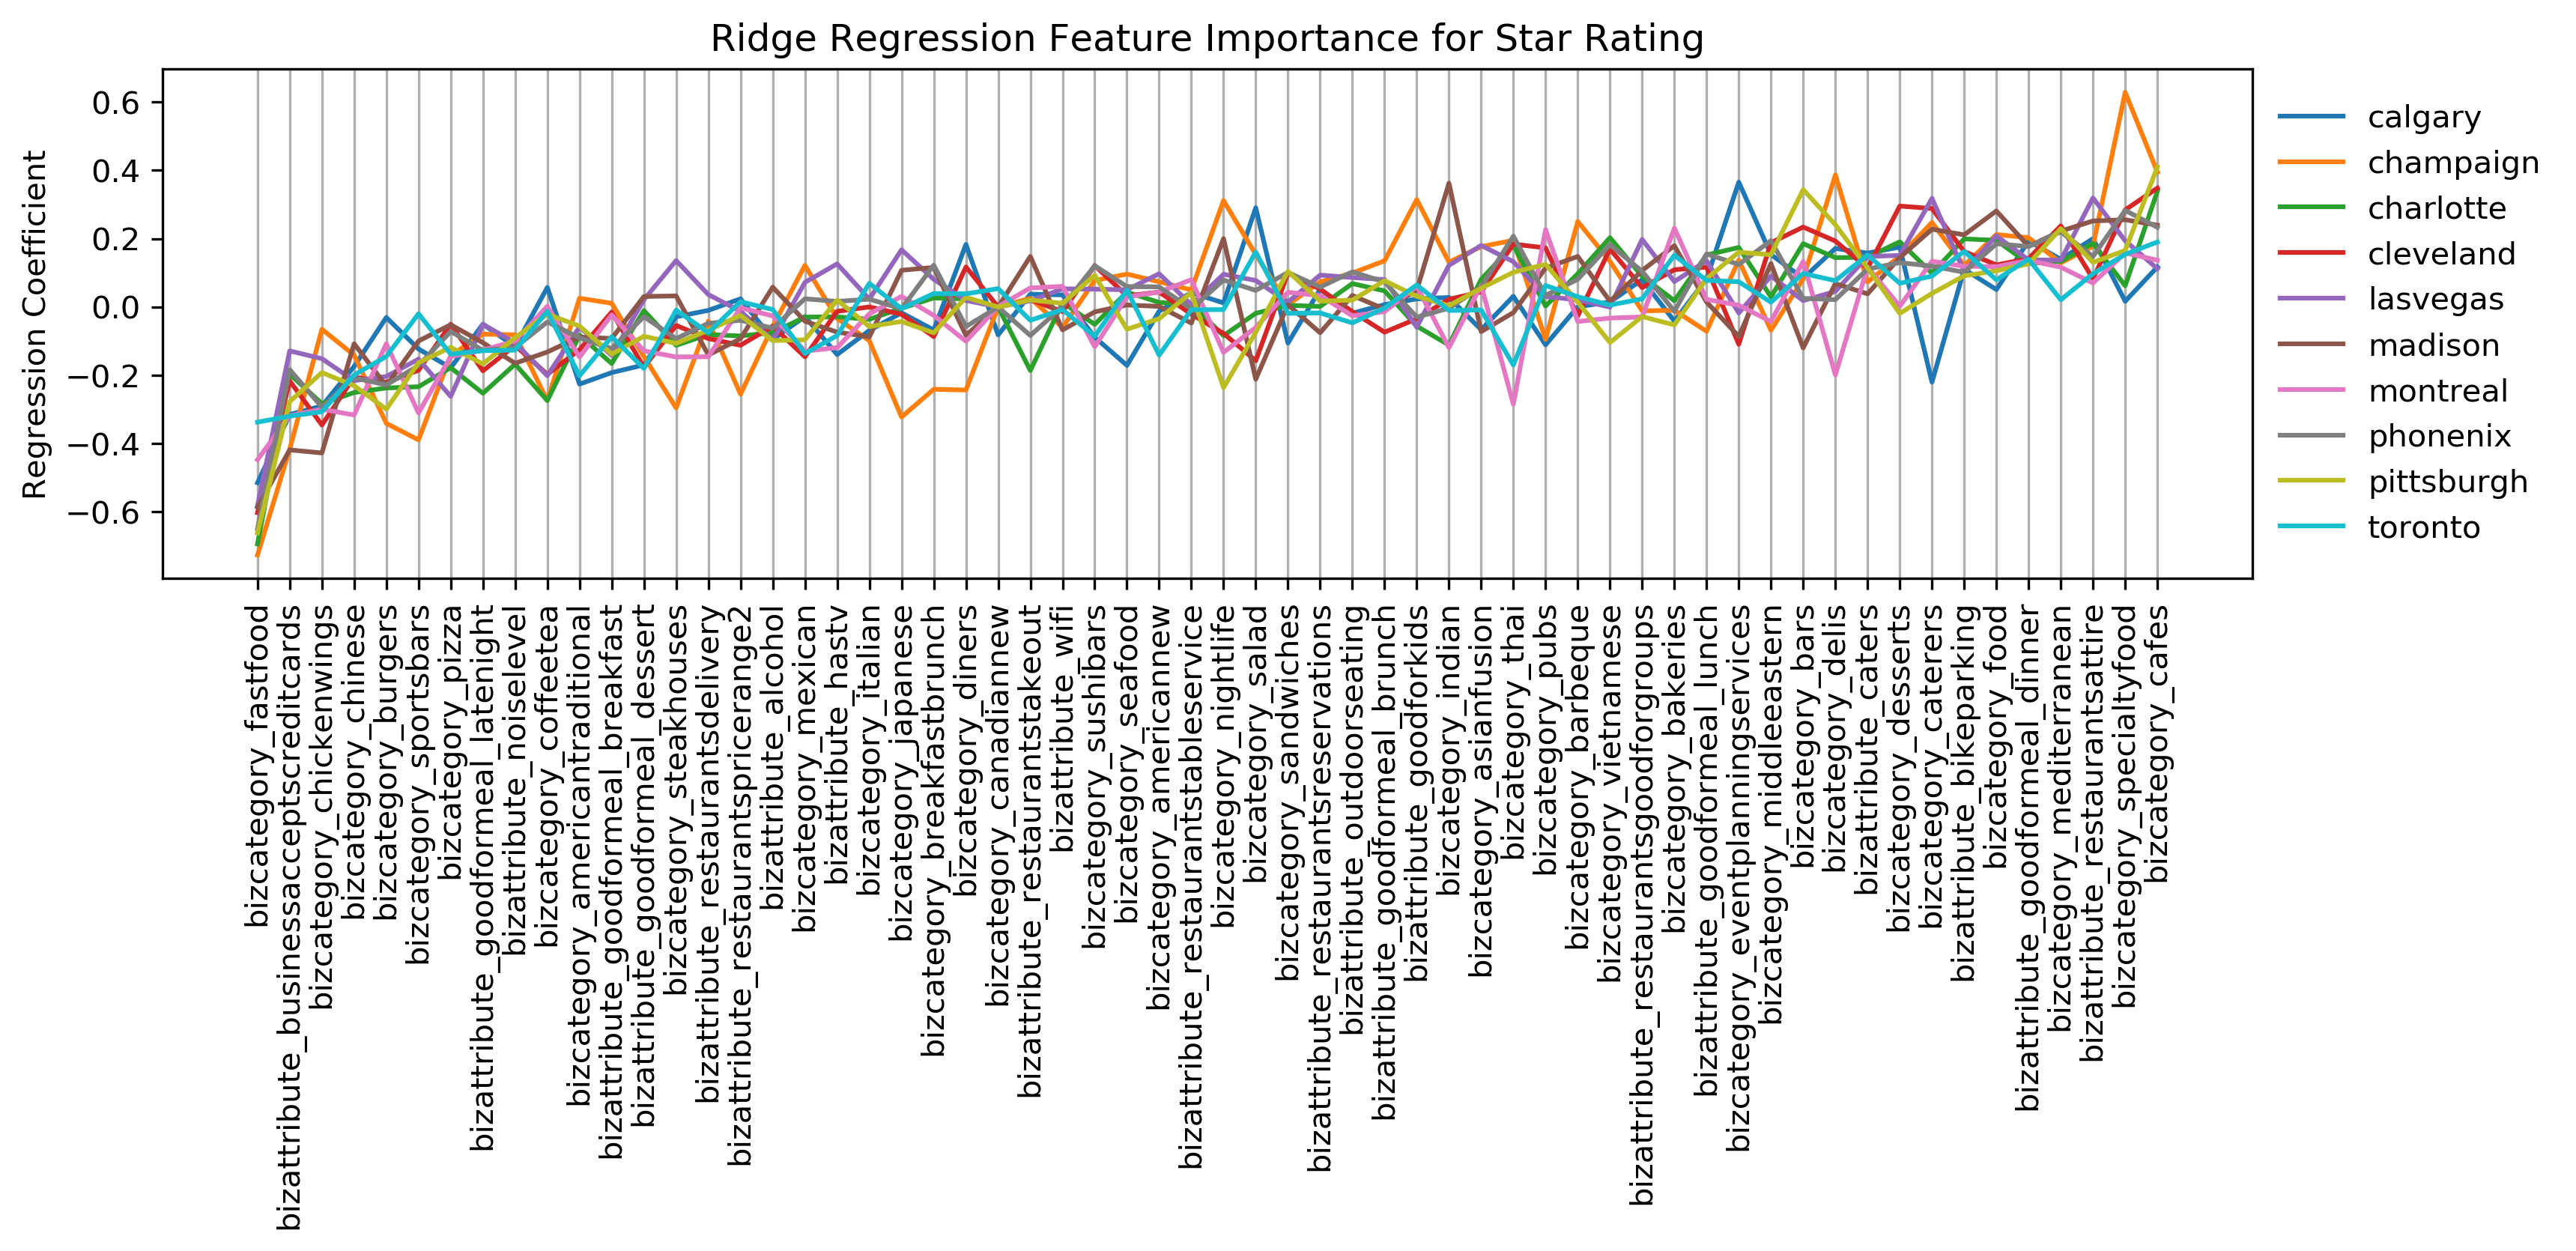

In [202]:
plt.figure(figsize=[12,3], dpi=300)
plt.plot(coeffs, '-')
plt.title('Ridge Regression Feature Importance for Star Rating')
plt.ylabel('Regression Coefficient')
plt.xticks(range(len(feats)), feats)
for item in plt.gca().get_xticklabels():
    item.set_rotation(90)
plt.legend([c[5:] for c in cities], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(axis='x')

plt.show()

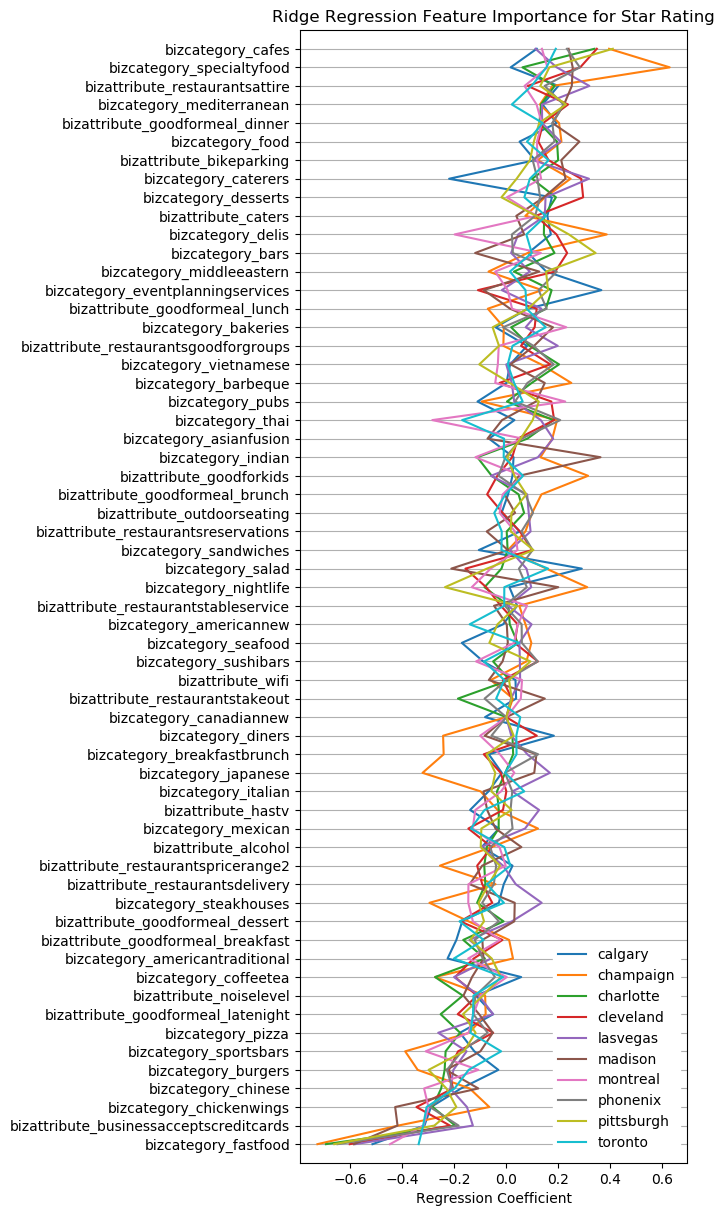

In [253]:
plt.figure(figsize=[5, 15], dpi=100)
plt.plot(coeffs, range(len(feats)), '-')
plt.ylim([-1, len(feats)])
plt.title('Ridge Regression Feature Importance for Star Rating')
plt.xlabel('Regression Coefficient')
plt.yticks(range(len(feats)), feats)
plt.legend([c[5:] for c in cities], loc='lower right', frameon=True, edgecolor='w', facecolor='w', framealpha=1)
plt.grid(axis='y')

plt.show()